In [ ]:
# pip install --upgrade jupyter_http_over_ws>=0.0.7 && jupyter serverextension enable --py jupyter_http_over_ws
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8899 --NotebookApp.port_retries=0
# https://www.data-in.ru/data-catalog/datasets/186/ # 01.01.2018 — 30.10.2021
# https://trudvsem.ru/opendata/datasets # 03.11.2022, 01.02.23

In [ ]:
import pandas as pd
import pickle, os
import numpy as np
import datetime as dt
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns, re
from zipfile import ZipFile as zp
from scipy.stats import kurtosis

### before

In [ ]:
base_dir = './'
#_dataset_date = '03.11.2022'
#_dataset_date = '29.12.2022'
#_dataset_date = '08.08.2023'
_dataset_date = ''

In [ ]:
with open(os.path.join(base_dir, f"cv_raw{'_'+_dataset_date if len(_dataset_date) else _dataset_date}_truncated.pickle"), 'rb') as pf:
    df = pickle.load(pf)
len(df)

7595113

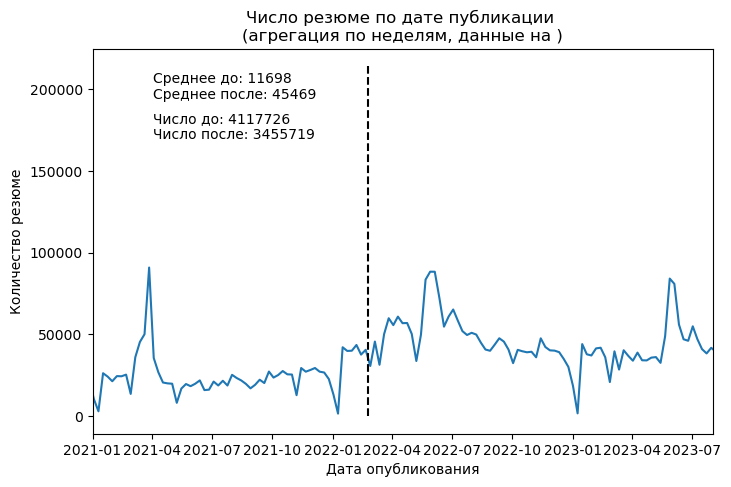

In [ ]:
cv = df.set_index('published_date').resample('W').count().reset_index()

cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
#cv = cv[cv['publish_month'] != '01']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(cv['published_date'], cv['id'])
ax.vlines(dt.datetime(2022, 2, 24), 0, cv['id'].max(), colors='k', linestyles='--')
ax.set_xlim(['2021-01-01', '2023-08-01'])
_before = cv[cv['published_date'] < '2022-02-24']['id']
_after = cv[cv['published_date'] >= '2022-02-24']['id']
fig.text(0.2, 0.78, f"Среднее до: {int(_before.mean())}\nСреднее после: {int(_after.mean())}", ha='left')
fig.text(0.2, 0.70, f"Число до: {_before.sum()}\nЧисло после: {_after.sum()}", ha='left')
plt.title(f'Число резюме по дате публикации \n(агрегация по неделям, данные на {_dataset_date})')
plt.xlabel('Дата опубликования')
plt.ylabel('Количество резюме')
plt.show()

In [ ]:
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
#cv = cv[cv['publish_month'] != '01']

def _agg(g):
    return np.mean(g.set_index('published_date').resample('W').count()['id'])

cv_mean_count_diff = None
for idx, g in cv.groupby(['region_code']):
    region_code = np.min(g.region_code)
    _before = g[g['published_date'] < '2022-02-24'][['id', 'published_date', 'region_code']]
    _after = g[g['published_date'] >= '2022-02-24'][['id', 'published_date', 'region_code']]
    _diff = _agg(_after) - _agg(_before)
    cv_mean_count_diff = pd.concat([cv_mean_count_diff,
                  pd.DataFrame.from_dict({'region_code' : region_code, 'cv_mean_count_diff' : _diff}, orient='index').T])
cv_mean_count_diff2022 = cv_mean_count_diff.rename(columns={'cv_mean_count_diff' : 'cv_mean_count_diff2022'}).reset_index(drop=True)

In [ ]:
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] == '02']

def _agg(g):
    return np.mean(g.set_index('published_date').resample('W').count()['id'])

cv_mean_count_diff = None
for idx, g in cv.groupby(['region_code']):
    region_code = np.min(g.region_code)
    _before = g[g['published_date'] < '2022-02-01'][['id', 'published_date', 'region_code']]
    _after = g[g['published_date'] >= '2022-02-01'][['id', 'published_date', 'region_code']]
    _diff = _agg(_after) / _agg(_before)
    cv_mean_count_diff = pd.concat([cv_mean_count_diff,
                  pd.DataFrame.from_dict({'region_code' : region_code, 'cv_mean_count_diff' : _diff}, orient='index').T])
cv_mean_count_difffeb = cv_mean_count_diff.rename(columns={'cv_mean_count_diff' : 'cv_mean_count_difffeb'}).reset_index(drop=True)

In [ ]:
# расчёт эксцесса с 2021-01-01
cv = df.groupby('region_name').resample('W', on='published_date').count()[['id']].reset_index()

cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] != '01']

k = {}
for idx, g in cv.groupby('region_name'):
    k[idx] = kurtosis(g['id'], fisher=True)
excess_value = pd.Series(k).sort_values()
excess_binary = excess_value < 0.5
selected_regions = excess_value[excess_binary].index.to_list()

In [ ]:
pd.concat([excess_value, excess_binary], axis=1)\
          .reset_index()\
          .rename(columns={0:'excess_value', 1:'excess_binary', 'index':'region_name'})\
          .to_csv(os.path.join(base_dir, f'cv_excess_{before_date}.csv'), sep=';', index=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 15))
ax.barh(y=[i for i, _ in enumerate(excess_value)], width=[i for i in excess_value])
#ax.set_yticklabels(k.index.to_list())
ax.bar_label(ax.containers[0], labels=excess_value.index.to_list(), label_type='edge')

In [ ]:
# отобранные регионы по величине эксцесса
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[:8]+'01')
cv = cv.drop_duplicates(['id']).groupby(['region_name', 'publish_month']).count().reset_index()
cv = cv[cv['region_name'].apply(lambda x: x in selected_regions)]
fig = px.line(data_frame=cv, x="publish_month", y="id", color='region_name', render_mode='webgl',
              title=f'Число резюме по дате публикации \n(агрегация по месяцам, данные на {before_date})')
fig.add_vline(x="2022-02-24", line_width=3, line_dash="dash", line_color="green")
fig.show()

### after

In [ ]:
base_dir = './'
before_date = '03.11.2022'
after_date = '01.02.2023'

In [ ]:
with open(os.path.join(base_dir, f'cv_raw_{after_date}_truncated.pickle'), 'rb') as pf:
    df = pickle.load(pf)
len(df)

503853

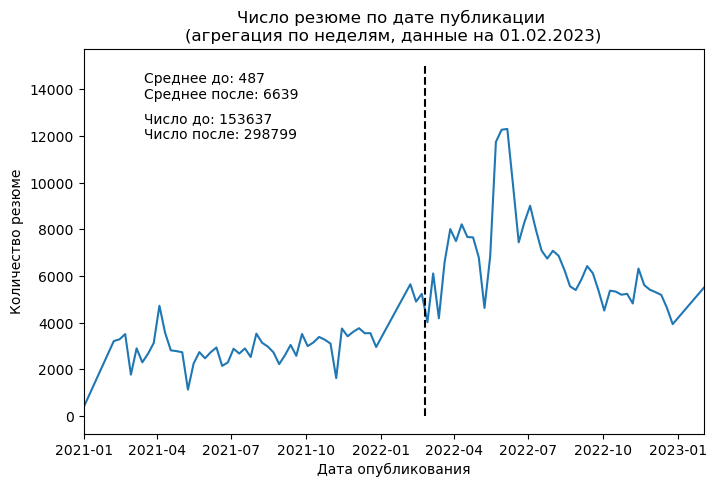

In [ ]:
cv = df.set_index('published_date').resample('W').count().reset_index()

cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] != '01']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(cv['published_date'], cv['id'])
ax.vlines(dt.datetime(2022, 2, 24), 0, 1.5e4, colors='k', linestyles='--')
ax.set_xlim(['2021-01-01', '2023-02-01'])
_before = cv[cv['published_date'] < '2022-02-24']['id']
_after = cv[cv['published_date'] >= '2022-02-24']['id']
fig.text(0.2, 0.78, f"Среднее до: {int(_before.mean())}\nСреднее после: {int(_after.mean())}", ha='left')
fig.text(0.2, 0.70, f"Число до: {_before.sum()}\nЧисло после: {_after.sum()}", ha='left')
plt.title(f'Число резюме по дате публикации \n(агрегация по неделям, данные на {after_date})')
plt.xlabel('Дата опубликования')
plt.ylabel('Количество резюме')
plt.show()

In [ ]:
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
#cv = cv[cv['publish_month'] != '01']

def _agg(g):
    return np.mean(g.set_index('published_date').resample('W').count()['id'])

cv_mean_count_diff = None
for idx, g in cv.groupby(['region_code']):
    region_code = np.min(g.region_code)
    _before = g[g['published_date'] < '2022-02-24'][['id', 'published_date', 'region_code']]
    _after = g[g['published_date'] >= '2022-02-24'][['id', 'published_date', 'region_code']]
    _diff = _agg(_after) - _agg(_before)
    cv_mean_count_diff = pd.concat([cv_mean_count_diff,
                  pd.DataFrame.from_dict({'region_code' : region_code, 'cv_mean_count_diff' : _diff}, orient='index').T])
cv_mean_count_diff2023 = cv_mean_count_diff.rename(columns={'cv_mean_count_diff' : 'cv_mean_count_diff2023'}).reset_index(drop=True)

In [ ]:
# расчёт эксцесса с 2021-01-01
cv = df.groupby('region_name').resample('W', on='published_date').count()[['id']].reset_index()

cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[5:7])
cv = cv[cv['publish_month'] != '01']

k = {}
for idx, g in cv.groupby('region_name'):
    k[idx] = kurtosis(g['id'], fisher=True)
excess_value = pd.Series(k).sort_values()
excess_binary = excess_value < 0.5
selected_regions = excess_value[excess_binary].index.to_list()

In [ ]:
pd.concat([excess_value, excess_binary], axis=1)\
          .reset_index()\
          .rename(columns={0:'excess_value', 1:'excess_binary', 'index':'region_name'})\
          .to_csv(os.path.join(base_dir, f'cv_excess_{after_date}.csv'), sep=';', index=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 15))
ax.barh(y=[i for i, _ in enumerate(excess_value)], width=[i for i in excess_value])
#ax.set_yticklabels(k.index.to_list())
ax.bar_label(ax.containers[0], labels=excess_value.index.to_list(), label_type='edge')

In [ ]:
# отобранные регионы по величине эксцесса
cv = df.copy()
cv['publish_month'] = cv['published_date'].apply(lambda x: str(x)[:8]+'01')
cv = cv.drop_duplicates(['id']).groupby(['region_name', 'publish_month']).count().reset_index()
cv = cv[cv['region_name'].apply(lambda x: x in selected_regions)]
fig = px.line(data_frame=cv, x="publish_month", y="id", color='region_name', render_mode='webgl',
              title=f'Число резюме по дате публикации \n(агрегация по месяцам, данные на {before_date})')
fig.add_vline(x="2022-02-24", line_width=3, line_dash="dash", line_color="green")
fig.show()

In [ ]:
#########

In [ ]:
cv_mean_count_diff2022.set_index('region_code')\
    .join(cv_mean_count_diff2023.set_index('region_code'), how='left')\
    .join(cv_mean_count_difffeb.set_index('region_code'), how='left')\
    .to_csv(os.path.join(base_dir, 'cv_mean_count_diff.csv'), index=True, sep=';')